# VQE Demo

This is a short Notebook showcasing the usage of our VQE module and most of its important features.

As with all Demo Notebooks, you need to start the Simulator and the Quil Compiler in the background by typing `qvm -S` and `quilc -S` in two open and disposable terminal windows.

## Short Intro: The Variational Quantum Eigensolver (VQE)
Let us begin with a very brief review of the Variational Quantum Eigensolver (VQE) to get the nomenclature sorted out. The aim of VQE is to find the ground state and/or ground state energy of a given cost hamiltonian $\hat{H}_\mathrm{cost}$. To do so, one prepares a trial state $\left| \psi (\vec{\gamma})\right> = \hat{U}(\vec{\gamma}) \left| 0 \right>$ by applying a parametric program $\hat{U}(\vec{\gamma})$ to the initial state $\left| 0 \right>$, and then measures its energy expectation value with respect to the cost Hamiltonian, $\left<\hat{H}_\mathrm{cost}\right>(\vec{\gamma}) = \left< \psi(\vec{\gamma}) \right|\hat{H}\left| \psi(\vec{\gamma})\right>$. This expectation value is then minimized by optimizing the parameters $\vec{\gamma}$ in a classical optimizer until a minimum of $\left<\hat{H}_\mathrm{cost}\right>(\vec{\gamma})$ is found for a parameter set $\vec{\gamma}^*$. The lowest energy eigenstate of $\hat{H_\mathrm{cost}}$ can now be prepared by applying $\hat{U}(\vec{\gamma}^*)$ to $\left| 0 \right>$, and its energy is given by $E_0 = \left< \psi(\vec{\gamma}^*) \right|\hat{H}_\mathrm{cost}\left| \psi(\vec{\gamma}^*)\right>$

Before we begin, let us import all neccesary libraries:

In [1]:
# The usual combination of scipy, numpy and matplotlib
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# The pyquil dependencies
from pyquil.paulis import PauliSum, PauliTerm
from pyquil.api import WavefunctionSimulator
from pyquil.quil import Program
from pyquil.gates import RY, H

# A finally the cost functions
from forest_qaoa.vqe.cost_function import PrepareAndMeasureOnWFSim, PrepareAndMeasureOnQVM
from forest_qaoa.qaoa.cost_function import QAOACostFunctionOnWFSim

# And one our QAOA parameter classes
from forest_qaoa.qaoa.parameters import StandardParams

## Setting up the problem

We start by creating a cost hamiltonian `hamiltonian` and state preparation program `prepare_ansatz`:

In [2]:
# create the cost hamiltonian
hamiltonian = PauliSum.from_compact_str("1.0*X0")

# and the parametric state preparation program:
prepare_ansatz = Program() # built an empty program
params = prepare_ansatz.declare("params", # add a classical register to store the values in 
                                memory_type="REAL", memory_size=1)
#prepare_ansatz.inst(H(0))
prepare_ansatz.inst(RY(params[0], 0))

Next we can create a cost function, which can be passed to a classical optimizer later. We do this by using `vqe.cost_function.PrepareAndMeasureOnWFSim`, a class that combines a cost hamiltonian `hamiltonian` and a state preparation circuit `prepare_ansatz` into a cost function that can be passed to any classical optimizer. The additional arguments have the following meaning:

- **param make_memory_map**:  A function that creates a memory map from the array of parameters
- **sim**: A WavefunctionSimulator instance to get the wavefunction from.
- **scalar_cost_function**: This option controls whether the cost function returns only the
  expectation value, or also its standard deviation. It also determines whether the cost function takes an additional argument `nshots`, which specifies how many samples to use for calculating the energy expectation value.
  
  If you are not using a custom optimizer that knows what to do with these options, you should
  set it to `True` and specify how many shots to use for sampling in `nshots`.
- **nshots**: If `scalar_cost_function=True` is passed, `nshots` has to be
    specified here. If `noisy=False` it has no effect in wavefunction-based simulators.
- **noisy**: If this is set to `True`, simulated measurement noise is added to the output.
  This can be useful, if one wants to test how well the optimizer being used works with sampling noise,
  and how many shots one should take to get good results.
- **enable_logging**: If set to `True`, a log is created which contains the parameter and function
   values at each function call. It is a list of namedtuples of the form
   ("x", "fun"), and is stored in `cost_function.log`. 

In [3]:
# create the cost_function with our ansatz and hamiltonian:
sim = WavefunctionSimulator()
cost_fun = PrepareAndMeasureOnWFSim(prepare_ansatz=prepare_ansatz,
                                    make_memory_map=lambda p: {"params": p},
                                    hamiltonian=hamiltonian,
                                    sim=sim,
                                    scalar_cost_function=False,
                                    noisy=True)

With the cost function set up, let us have a look at it graphically. Since we have specified `scalar_cost_function = False`, we have to pass the argument `nshots`, and the return values are a tuple of the form `(exp_val, std_dev)`. We plot the cost functions for $\gamma \in [-3, 2]$:

In [4]:
gammas = np.linspace(-3,2,200)
exp_vals = np.empty_like(gammas)
std_devs = np.empty_like(gammas)
for i, v in enumerate(gammas):
    exp_vals[i], std_devs[i] = cost_fun([v], nshots=3)

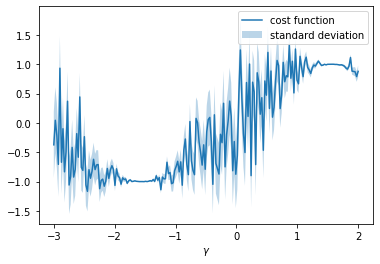

In [5]:
plt.plot(gammas, exp_vals, label="cost function")
plt.fill_between(gammas, exp_vals - std_devs, exp_vals + std_devs, alpha=0.3, label="standard deviation")
plt.xlabel(r"$\gamma$")
plt.legend()
plt.show()

This is quite noisy, but let us try optimizing $\gamma$ nevertheless. Because `scipy.optimize.minimize` expects a objective function / cost function that returns only a scalar vaule, we need to reinstantiate the cost functions with `scalar_cost_function = True`:

In [6]:
# create the cost_function with our ansatz and hamiltonian:
sim = WavefunctionSimulator()
cost_fun = PrepareAndMeasureOnWFSim(prepare_ansatz=prepare_ansatz,
                                    make_memory_map=lambda p: {"params": p},
                                    hamiltonian=hamiltonian,
                                    sim=sim,
                                    scalar_cost_function=True,
                                    nshots=3,
                                    enable_logging=True,
                                    noisy=True)

Now this cost function can be passed to `scipy.optimize.minimize` with an initial value for $\gamma$:

In [7]:
# and finally minimize it:
gamma0 = [0]
out = minimize(cost_fun, gamma0, method="Cobyla")

`out` should now contain the minimal eigenvalue of `hamiltonian` as the minimal function value and the correct parameters for `prepare_ansatz` to prepare the corresponding eigenstate. We can compare this with the real minimal eigenvalue, by printing `hamiltonian` as a matrix:

In [8]:
print("The output of scipy.optimize.minimize:\n",out)
print("\n And the eigenvalues of the hamiltonian:\n", np.linalg.eigvalsh(hamiltonian.matrix()))

The output of scipy.optimize.minimize:
      fun: -0.9277959852157337
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 19
  status: 1
 success: True
       x: array([-1.9999])

 And the eigenvalues of the hamiltonian:
 [-1.  1.]


We see that we didn't find the ground state exactly, so let's look into what actually happened.

Since we set `enable_logging=True`, we can see how we converged to this solution by plotting the function values from `cost_function.log`. This is a list of namedtuples containing the parameter values and function values `("x", "fun")` at each call to the cost function. We can extract them using a list comprehension:

In [9]:
param_log = np.array([step.x for step in cost_fun.log])
fun_log = np.array([step.fun for step in cost_fun.log])

# create an array for the x-axis:
x = np.arange(out["nfev"])

and plot function and paramater values side by side:

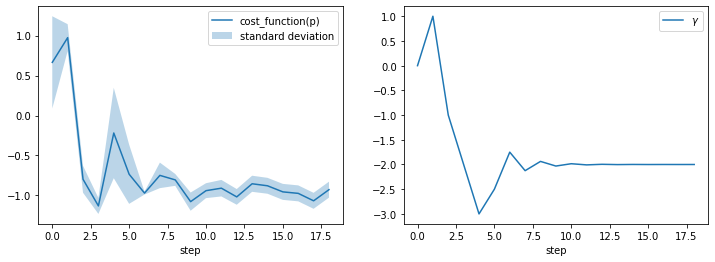

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(x, fun_log[:,0], label="cost_function(p)")
ax[0].fill_between(x, fun_log[:,0] - fun_log[:,1], fun_log[:,0] + fun_log[:,1],
                   alpha=0.3, label="standard deviation")
ax[0].legend()
ax[0].set_xlabel("step")

ax[1].plot(x, param_log, label=r"$\gamma$")
ax[1].legend()
ax[1].set_xlabel("step");

As we can see, the uncertainties over the true function value (shown by the bright blue background on the left side) are fairly large. Maybe we can help the optimizer, by taking more samples and hence decreasing the standard deviations of the function values?

In [11]:
# create the cost_function with our ansatz and hamiltonian:
cost_fun = PrepareAndMeasureOnWFSim(prepare_ansatz=prepare_ansatz,
                                    make_memory_map=lambda p: {"params": p},
                                    hamiltonian=hamiltonian,
                                    sim=sim,
                                    scalar_cost_function=True,
                                    nshots=20,              # <- this the line, that we changed
                                    enable_logging=True,
                                    noisy=True)

In [12]:
# and minimize it:
gamma0 = [0]
out = minimize(cost_fun, gamma0, method="Cobyla")

Let us have a look at the obtained results again:

In [13]:
print("The output of scipy.optimize.minimize:\n",out)
print("\n And the eigenvalues of the hamiltonian:\n", np.linalg.eigvalsh(hamiltonian.matrix()))

The output of scipy.optimize.minimize:
      fun: -0.99999999239618
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 25
  status: 1
 success: True
       x: array([-1.57070078])

 And the eigenvalues of the hamiltonian:
 [-1.  1.]


This looks much better, and the logs will surely confirm this:

In [14]:
param_log = np.array([step.x for step in cost_fun.log])
fun_log = np.array([step.fun for step in cost_fun.log])

# create an array for the x-axis:
x = np.arange(out["nfev"])

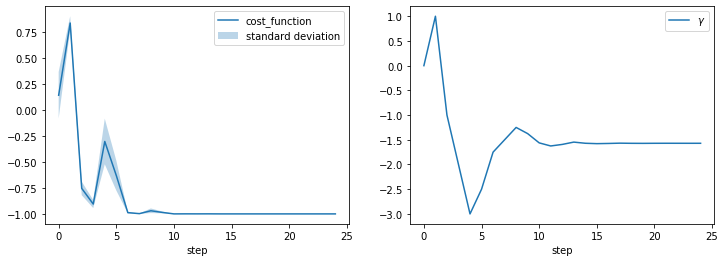

In [15]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(x, fun_log[:,0], label="cost_function")
ax[0].fill_between(x, fun_log[:,0] - fun_log[:,1], fun_log[:,0] + fun_log[:,1], alpha=0.3,
                   label="standard deviation")
ax[0].legend()
ax[0].set_xlabel("step")

ax[1].plot(x, param_log[:], label=r"$\gamma$")
ax[1].legend()
ax[1].set_xlabel("step");

Now the standard deviation of the function calls is greatly reduced. 

## Towards QAOA

A more detailled explanation of our QAOA library can be found in the Notebooks `QAOAWorkflowDemo.ipynb` and `QAOAParameterDemo.ipynb`. Here we only explain how it can be regarded as a special case of VQE.

For QAOA - which was originally designed for solving classical optimization problems - the Hamiltonian is diagonal in the computational basis, and typically contains at most 2-qubit terms (there is nothing to prevent one from considering k-qubit terms, however the limitations of near-term hardware make the k = 2 case the most practically feasible). 

In [16]:
hamiltonian = PauliSum.from_compact_str("(-1.0)*Z0*Z1 + 0.8*Z0 + (-0.5)*Z1")

Since the parameters for a QAOA circuit have more structure than just a flat array, and there exist multiple possible parametrizations, we provide special classes to hold the parameters for a QAOA circuit. We will use the `StandardParams` class here. We can create these initial parameters like this:

Also, there exists an educated guess for good initial parameters, depending on the Hamiltonian.

In [17]:
params = StandardParams.linear_ramp_from_hamiltonian(hamiltonian, n_steps=10)

The QAOA cost function has a fixed structure, with a corresponding fixed state preparation program. We therefore provide special cost functions for QAOA, which inherit most of the behaviour from `vqe.cost_functions.PrepareAndMeasure...`. They are created via

In [18]:
qaoa_cost_fun = QAOACostFunctionOnWFSim(hamiltonian,
                                        params,
                                        sim,
                                        scalar_cost_function=True,
                                        nshots=1000,
                                        noisy=True,
                                        enable_logging=True)

Unlike for `PrepareAndMeasureOnWFSim`, we didn't have to pass a state preparation circuit `prepare_ansatz` or function to generate memory maps `make_memory_map` to `QAOACostFunctionOnWFSim`. These are already fixed by the fact that we want to do QAOA on a given hamiltonian. Instead we had to pass the QAOA parameters `parameters` to it.

If we want to find the optimal parameters, we have to provide our optimizer with some initial parameter set. Currently our `params` are of type `StandardParameters`, which is not something that `scipy.optimize.minimize` recognizes. We can obtain a `np.array` with all of our parameters in a 1D array using the `params.raw()` method, and then pass these to `scipy.optimize.minimize`:

In [19]:
p0 = params.raw()
out = minimize(qaoa_cost_fun, p0, tol=1e-3, method="Cobyla", options={"maxiter": 500})

In [20]:
print("The output of scipy.optimize.minimize:\n",out)
print("\n And hamiltonian as a matrix:\n", hamiltonian.matrix())

The output of scipy.optimize.minimize:
      fun: -1.181957227339198
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 159
  status: 1
 success: True
       x: array([1.68715791e+00, 5.76538552e-01, 4.66009105e-01, 4.49263336e-01,
       3.17765864e-01, 3.12232624e-01, 1.47027855e-01, 1.56367797e-01,
       1.44308389e-01, 6.23041008e-02, 9.02925260e-02, 8.61825096e-04,
       2.35715126e-01, 4.31224113e-01, 4.76138957e-01, 4.81181831e-01,
       3.25107391e-01, 5.17329852e-01, 5.93083943e-01, 6.62506084e-01])

 And hamiltonian as a matrix:
 [[-0.7+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.3+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  2.3+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -1.3+0.j]]


So we got close again, but not exactly there. If we want to have a look at the logs this time, it is a little more complicated. Our logging functionality simply appends the array of current parameters to the log. If we want to have them in terms of `betas` and `gammas` again, we can pipe them through the `params` instance again:

In [21]:
betas_log = []
gammas_log = []
for step in qaoa_cost_fun.log:
    params.update_from_raw(step.x)
    betas_log.append(params.betas)
    gammas_log.append(params.gammas)
betas_log = np.array(betas_log)
gammas_log = np.array(gammas_log)
    
fun_log = np.array([step.fun for step in qaoa_cost_fun.log])

# create an array for the x-axis:
x = np.arange(out["nfev"])

And now we can plot them;

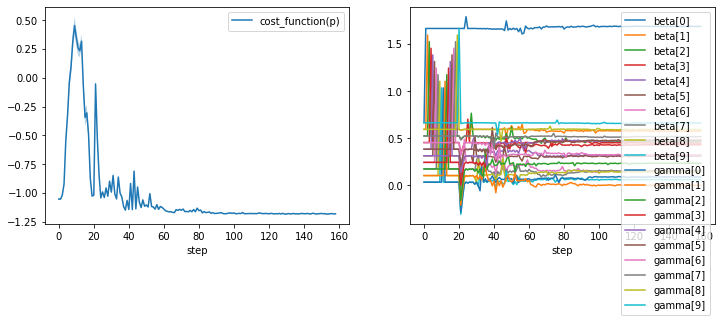

In [22]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(x, fun_log[:,0], label="cost_function(p)")
ax[0].fill_between(x, fun_log[:,0] - fun_log[:,1], fun_log[:,0] + fun_log[:,1], alpha=0.3)
ax[0].legend()
ax[0].set_xlabel("step")

for i in range(10):
    ax[1].plot(x, betas_log[:,i], label=f"beta[{i}]")
for i in range(10):
    ax[1].plot(x, gammas_log[:,i], label=f"gamma[{i}]")
ax[1].legend()
ax[1].set_xlabel("step");

### TODO: FIX THE FORMATTING HERE ###

We can also only plot the final, optimal parameters with the built-in `params.plot()` function:

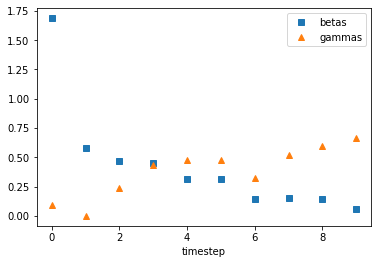

In [23]:
params.update_from_raw(out["x"])
params.plot()

## Implementation Details for the Statistics Nerd

The attentive observer will have noticed that we sometimes get function values below the minimal eigenvalue of the hamiltonian and then wondered, how we get this unphysical result. This is, because we "fake" the sampling noise when using the wavefunction based cost functions `PrepareAndMeasureOnWFSim` and `QAOACostFunctionOnWFSim`. We first calculate the true energy expectation value and variance via

$$
E(\vec{\gamma}) = \left<\psi(\vec{\gamma})\left| \hat{H} \right| \psi(\vec{\gamma})\right>
\qquad\mathrm{and}\qquad
\mathrm{var}(E)(\vec{\gamma}) = \left<\psi(\vec{\gamma})\left| \hat{H}^2 \right| \psi(\vec{\gamma})\right> - \left<\psi(\vec{\gamma})\left| \hat{H} \right| \psi(\vec{\gamma})\right>^2
$$

and then return, in accord with the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), this energy expectation value plus appropriately scaled gaussian noise and the standard deviation of the mean:

$$
\mathrm{cost\_function} (\vec{\gamma}) =
\left(
    E(\vec{\gamma}) +  \mathcal{N}\left(0, \sqrt{\frac{\mathrm{var}(E)(\vec{\gamma})}{\mathrm{nshots}}}\right),
\sqrt{\frac{\mathrm{var}(E)(\vec{\gamma})}{\mathrm{nshots}}}
\right)
$$

Now in the above case we used extremely small numbers of shots `n = 3` or `n = 20`, in which the central limit theorem doesn't really hold. Hence we get these unphysical results. But for more realistic cases one would take much larger numbers of shots to get acceptable results anyways.

On the other hand, the sampling based cost functions `PrepareAndMeasureOnQVM` and `QAOACostFunctionOnQVM` don't need to fake sampling noise and you are guaranteed to get physical results. This comes at the cost of much slower simulations, because a lot of random numbers have to be generated.